# [실습 5] 한국어 자연어 데이터셋을 이용한 리뷰 분석 프로젝트

## 실습 목표

---

1. `transformer` 라이브러리의 사전학습된 `Kobert`모델을 이용하여 NSMC task를 수행합니다.

2. 효율적인 학습을 위해 Bucketing을 이해하고 구현해봅니다.

3. `Koelectra`모델을 학습시켜 앞서 학습시킨 모델과 성능을 비교해봅니다.

## 1. 모듈 불러오기 및 환경설정

실습에 필요한 라이브러리를 불러옵니다.

In [29]:
# 기본 라이브러리 불러오기
import pandas as pd
from tqdm.notebook import tqdm  # 반복문의 진행 상태를 표시하는 라이브러리
import matplotlib.pyplot as plt

# 파이토치 관련 라이브러리 불러오기
import torch
from torch.optim import AdamW   # AdamW 옵티마이저
from torch.nn import functional as F    # 파이토치 함수: 다양한 활성화 함수 및 유틸리티 제공
from torch.utils.data import DataLoader, Dataset    # 데이터 로딩 및 사용자 정의 데이터셋을 위한 클래스
from sklearn.metrics import classification_report   # 모델 성능 평가를 위한 scikit-learn의 classification_report

이 코드를 통해 필요한 모든 라이브러리와 모듈을 불러왔으므로, 이제 딥러닝 모델의 구성 및 학습을 시작할 준비가 되었습니다.

이어서 딥러닝 모델 학습 시 사용할 하드웨어를 설정하도록 하겠습니다.

### 1.1 하드웨어 설정

In [30]:
from torch import cuda

# GPU 사용
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

딥러닝 모델의 연산이 GPU에서 수행될 수 있게 되면 학습 속도가 크게 향상됩니다. 만약 GPU가 없거나 사용할 수 없는 경우, CPU에서 연산이 수행됩니다.  

### 1.2 모델과 토크나이저 불러오기

첫 번째 실습에서 사용할 모델은 [KR-BERT](https://huggingface.co/snunlp/KR-Medium)입니다. KR-BERT(Korean BERT)는 한국어 텍스트 처리를 위해 특별히 훈련된 BERT 모델로, 기존 BERT의 한국어 성능 한계를 극복하기 위해 개발되었습니다.  

한국어 모델인 만큼 한국어 데이터셋(위키피디아, 뉴스 등)을 바탕으로 학습되었으며, 데이터 기반 토크화 기법을 사용하여 적은 토큰(기존 대비 27%)으로 성능 향상을 이룬 모델입니다.

모델의 대표적인 Subtask에는 개체명 인식(NER, Named Entity Recognition), 자연어 추론(NLI, Natural Language Inference), 문장 의미 유사도(SST, Semantic Textual Similarity) 등이 있으며, 이번 실습에서는 감성 분석(Sentiment Analysis)를 도전해보겠습니다.

감성 분석은 기본적으로 분류 문제에 해당하므로 문장 분류를 위해 `BertForSequenceClassification` 모델을 불러옵니다.

In [31]:
from transformers import BertForSequenceClassification, AutoTokenizer

# 'snunlp/KR-Medium'을 기반으로 시퀀스 분류를 위한 BERT 모델
# return_dict=False는 모델의 출력을 딕셔너리 형태가 아닌 튜플 형태로 받기 위한 설정
bertmodel = BertForSequenceClassification.from_pretrained('snunlp/KR-Medium', return_dict=False)

# 'snunlp/KR-Medium'에 해당하는 토크나이저
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-Medium", do_lower_case=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-Medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/vin_ah/miniconda3/envs/module1/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


- `BertForSequenceClassification`: BERT 모델을 시퀀스 분류 작업에 적용하기 위한 클래스입니다. 이 클래스는 BERT 모델의 출력에 분류를 위한 선형 레이어를 추가합니다.

- `AutoTokenizer`: 모델에 맞는 토크나이저를 자동으로 불러오기 위한 클래스입니다.

## 2. 데이터 불러오기 및 전처리

이번엔 데이터를 불러오도록 하겠습니다. 이번 시간에 활용될 데이터는 한국어 언어모델의 발전에 큰 기여를 한 [NSMC](https://github.com/e9t/nsmc) 데이터셋입니다.

NSMC(Naver Sentiment Movie Corpus)는 네이버 영화(2023.03.31 서비스 종료)에서 제공되던 영화 리뷰 데이터를 수집한 것으로, 전체 20만 개의 샘플로 구성됩니다.  

각 샘플에는 세 가지 항목의 데이터가 포함됩니다.
- `id`: 네이버에서 제공된 리뷰의 아이디

- `document`: 영화 감상평

- `label`: 긍/부정 평가(부정: 0, 긍정: 1)
    - 실제 평점은 1-10점으로 구성되었으며 세 구간으로 분할됨
    - 1-4점은 부정 평가
    - 9-10점은 긍정 평가
    - 5-8점에 해당하는 중립 평가는 데이터셋에서 제외

데이터셋의 전처리를 위해 우선 Pandas 데이터프레임으로 불러오겠습니다.
    

In [32]:
train_df = pd.read_csv('./ratings_train.txt', sep='\t')
test_df = pd.read_csv('./ratings_test.txt', sep='\t')

학습용 데이터프레임과 테스트용 데이터프레임의 일부를 살펴보겠습니다.

### [TODO] 두 데이터프레임의 앞부분 10줄을 출력해주세요.

In [33]:
# [YOUR CODE]
train_df.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [34]:
# [YOUR CODE]
test_df.head(10)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


### 2.1 불필요한 열 제거

실질적인 모델의 학습에는 평가 텍스트와 이에 해당하는 긍/부정 레이블만 필요합니다.  

`.drop()` 메서드를 사용하여 `id` 열을 제거해봅시다.

### [TODO] 각 데이터프레임에서 `id` 컬럼을 지워주세요.

In [35]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

아래와 같이 해당 열이 제거된 것을 확인할 수 있습니다.

In [36]:
print(train_df.shape)
print(test_df.shape)

(150000, 2)
(50000, 2)


### 2.2 문장 길이 파악

토큰화 과정에 들어가기 전에, 문장의 길이를 파악하는 것은 매우 중요합니다.  

텍스트 데이터 전처리 과정에서 문장 간의 길이가 크게 차이날 경우, 패딩과 길이 제한으로 인해 모델이 데이터를 안정적으로 학습하기 어려울 수 있습니다.  

그러므로 문장 길이를 시각화하여, 학습 전 토큰화 과정에서 데이터의 특징을 고려하는 데 참고할 만한 인사이트를 얻어봅시다.

학습용 데이터의 리뷰 길이를 모아 `train_len`에 리스트로 담아봅시다.

### [TODO] 학습 데이터의 리뷰 별 길이값을 추출하여, `train_len`리스트에 담아주세요.

In [37]:
train_len = [len(str(sen)) for sen in train_df.iloc[:, 0]]

In [38]:
train_len = train_df['document'].astype(str).apply(len)

문장 길이 데이터가 모였다면, 이를 히스토그램(도수분포표)으로 시각화해봅시다.

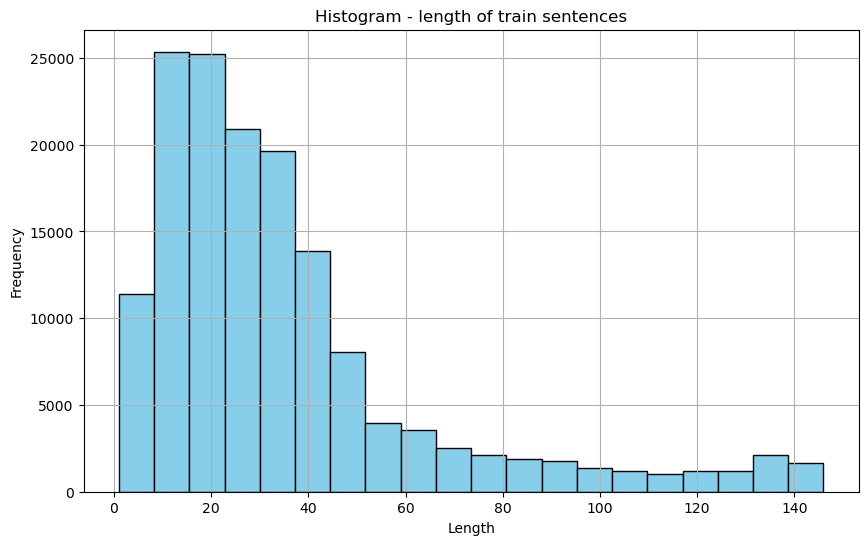

In [39]:
# 필요한 라이브러리를 가져옵니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. (가로 10, 세로 6)
plt.figure(figsize=(10, 6))

# 학습 데이터의 문장 길이에 대한 히스토그램
# bins는 히스토그램의 막대 개수를 의미하며, 색상은 'skyblue', 테두리 색상은 'black'으로 설정
plt.hist(train_len, bins=20, color='skyblue', edgecolor='black')

# 그래프의 제목을 설정
plt.title('Histogram - length of train sentences')

# x축과 y축의 라벨을 설정
plt.xlabel('Length')
plt.ylabel('Frequency')

# 그래프에 격자를 추가
plt.grid(True)

# 그래프를 화면에 표시
plt.show()

학습 데이터의 경우 대부분 150자 이내의 범위에 존재하는 것을 알 수 있습니다.  

또한 대부분의 데이터는 길이가 20에서 40 사이에 분포함을 알 수 있습니다.

이어서 테스트 데이터에 대해서도 같은 과정을 밟아보겠습니다.

### [TODO] 테스트 데이터에 대한 길이 값을 측정하여 히스토그램으로 표현해주세요.

위에서 진행한 내용과 동일한 절차대로 코드를 완성해주세요.

In [40]:
test_len = # [YOUR CODE]

plt.figure(figsize=(10, 6))
plt.hist(# [YOUR CODE], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram - length of test sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

SyntaxError: invalid syntax (1246728351.py, line 1)

학습 데이터와 크게 다르지 않습니다.  

이를 통해 우리는 문장 내 평균 128단어보다 적은 수의 단어가 존재할 것이라고 가정해보록 하겠습니다.

해당 정보를 변수에 할당하여 토큰화에 활용해보도록 합시다.

In [48]:
MAXLEN = 128

### 2.3 레이블 분포 파악

이번에는 레이블의 분포를 파악해보도록 하겠습니다.  

레이블의 분포가 불균형하다면, 모델이 자칫 잘못 학습될 수 있기 때문입니다.

`.value_counts()`메서드를 활용하여 레이블의 수를 세고, 이를 변수에 할당합니다.

In [ ]:
# 학습 데이터에서 'label' 열의 각 값의 빈도수를 계산
train_label_count = train_df['label'].value_counts()

# 테스트 데이터에서 'label' 열의 각 값의 빈도수를 계산
test_label_count = test_df['label'].value_counts()

모아진 레이블 분포를 위와 마찬가지로 히스토그램으로 표현해보겠습니다.

### [TODO] 레이블 분포에 대한 히스토그램을 그려주세요.

위와 같은 과정으로 진행해주시되, 헷갈리는 부분은 주석을 참고하여 코드를 완성해주세요.

In [ ]:
# 그래프의 크기를 설정 (가로 8, 세로 5)
plt.figure(figsize=(8, 5))

# 학습 데이터의 라벨 분포를 바 차트로 표현
# 색상은 'skyblue', 테두리 색상은 'black'으로 설정
train_label_count.plot(kind=# [YOUR CODE], color=# [YOUR CODE], edgecolor=# [YOUR CODE])

# 그래프의 제목을 설정
plt.title('Train label distribusion')

# x축과 y축의 라벨을 설정
plt.xlabel('Labels')
plt.ylabel('Frequency')

# x축의 라벨 회전 각도를 설정. 여기서는 0도로 설정하여 라벨이 수평으로 표시
plt.xticks(rotation=0)

# y축에만 격자를 추가
plt.grid(axis='y')

# 그래프의 레이아웃을 조정
plt.tight_layout()

# 그래프를 화면에 표시
plt.show()

SyntaxError: '(' was never closed (788121838.py, line 6)

In [ ]:
# 바 차트 그리기
plt.figure(figsize=(8, 5))
test_label_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Test label distribusion')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

학습 데이터와 테스트 데이터 모두 레이블 분포에 거의 차이가 없습니다.  

이 정도면 데이터 불균형에 대한 걱정 없이 모델을 학습시켜도 되겠습니다.

### 2.4 결측치 제거

이어서 데이터에 결측치가 있는지 확인해보도록 하겠습니다.

데이터프레임의 `.info()` 메서드를 사용하면 열 별 데이터의 타입과 결측 여부를 간단하게 확인할 수 있습니다.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   document  149995 non-null  object
 1   label     150000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  49997 non-null  object
 1   label     50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


학습 데이터와 테스트 데이터에서 각자 5개와 3개의 결측치가 있다고 보고됩니다. 이를 자세하게 확인해보도록 하겠습니다.  

In [ ]:
train_df.isnull().sum()

document    5
label       0
dtype: int64

In [ ]:
test_df.isnull().sum()

document    3
label       0
dtype: int64

결측치가 확인되었습니다. 해당 샘플은 학습에 사용할 수 없으니 제거하도록 하겠습니다.  

In [41]:
# 학습 데이터에서 결측값을 포함하는 행을 제거
train_df = train_df.dropna(axis=0)

# 테스트 데이터에서 결측값을 포함하는 행을 제거
test_df = test_df.dropna(axis=0)

# 데이터의 형태(행과 열의 수)를 출력
print(train_df.shape)
print(test_df.shape)

(149995, 2)
(49997, 2)


### 2.5 중복 데이터 제거

중복되는 데이터도 학습에 지장을 줍니다. 해당 데이터를 찾아 제거하도록 하겠습니다.

우선 중복되는 데이터를 찾아 수를 세어보겠습니다.

In [42]:
# 학습 데이터에서 중복된 행을 찾은 후
train_duplicated = train_df[train_df.duplicated()]

# 중복된 행들을 출력
train_duplicated

,document,label
1058,4,0
1097,쵝오,1
1483,최고,1
1707,재밌다,1
1804,볼만함,1
...,...,...
149919,짱,1
149949,OO 영화,0
149960,지루하다,0
149966,1,0


학습데이터에서 꽤나 많은 수의 중복 데이터가 발견됩니다. 테스트 데이터도 살펴보겠습니다.

### [TODO] 테스트 데이터에서 중복되는 행을 찾아 수를 출력해주세요.

In [43]:
# 테스트 데이터에서 중복되는 행의 수를 집계
# [YOUR CODE]

두 데이터를 합치면 4000여 개 이상의 리뷰에서 중복값이 발견됩니다. 해당 샘플들을 전부 삭제해줍시다.

In [44]:
# document 열에서 모든 중복데이터 제거 후 인덱스 재정렬
train_df.drop_duplicates(subset=['document'], inplace=True)
test_df.drop_duplicates(subset=['document'], inplace=True)

### 2.6 데이터 일부 사용
긍/부정 평가를 위해 150000여 개의 데이터로 학습시키는 것은 다소 과도합니다. 이 중 20퍼센트의 데이터만 활용하도록 합시다.

In [45]:
train_df = train_df.sample(frac=0.2, random_state=42)
test_df = test_df.sample(frac=0.2, random_state=42)

print(train_df.shape)
print(test_df.shape)

(29236, 2)
(9831, 2)


### 2.6 데이터셋 클래스 선언

데이터셋 클래스를 선언하도록 하겠습니다.  

아래 데이터셋은 PyTorch의 Dataset 클래스를 상속받아 정의하며, 이를 통해 데이터 로딩 및 전처리를 효율적으로 수행할 수 있습니다.

또한 `DataLoader`와 함께 사용하면 배치 단위로 데이터를 불러와 모델 학습에 사용할 수 있습니다.  

이 클래스는 주어진 데이터프레임(`df`), 토크나이저(`tokenizer`), 그리고 최대 시퀀스 길이(`maxlen`)를 기반으로 텍스트 데이터를 처리하고 모델에 입력할 수 있는 형태로 반환합니다.

In [46]:
# PyTorch의 Dataset 클래스를 상속받아 사용자 정의 데이터셋 클래스를 정의
class NSMCDataset(Dataset):

    # 초기화 메서드
    def __init__(self, df, tokenizer, maxlen):
        # 데이터프레임, 토크나이저, 최대 시퀀스 길이를 인스턴스 변수로 저장
        self.dataset = df
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    # 데이터셋의 전체 길이(항목 수)를 반환하는 메서드
    def __len__(self):
        return len(self.dataset)

    # 주어진 인덱스에 해당하는 데이터 항목을 반환하는 메서드
    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 행을 가져옴
        row = self.dataset.iloc[idx].values
        text = row[0]  # 텍스트 데이터
        y = row[1]     # 라벨

        # 텍스트를 토크나이저를 사용하여 토큰화하고, 필요한 형태로 변환
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.maxlen,
            pad_to_max_length=True,
            add_special_tokens=True
            )

        # 입력 ID와 attention mask를 추출
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        # 입력 ID, attention mask, 라벨을 반환
        return input_ids, attention_mask, y

- `__init__`: 초기화 작업을 수행합니다. 주어진 데이터프레임, 토크나이저, 최대 시퀀스 길이를 인스턴스 변수로 저장합니다.

- `__len__`: 데이터셋의 전체 길이(항목 수)를 반환합니다.

- `__getitem__`: 주어진 인덱스에 해당하는 데이터 항목을 반환합니다. 이 메서드에서는 텍스트 데이터를 토크나이저를 사용하여 토큰화하고, 필요한 형태로 변환한 후, 입력 ID와 attention mask를 추출하여 반환합니다.

`__getitem__` 내부의 토크나이저에서 일어나는 과정을 자세히 설명드리자면 다음과 같습니다.

```
inputs = self.tokenizer(
    text,  # 토큰화할 텍스트
    return_tensors='pt',  # 반환되는 텐서의 형태
    truncation=True,  # 길이 제한
    max_length=self.maxlen,  # 시퀀스의 최대 길이
    pad_to_max_length=True,  # 패딩
    add_special_tokens=True  # 특별 토큰 추가
)
```

- `text`: 토큰화할 원본 텍스트입니다.

- `return_tensors`: 반환되는 데이터의 형태를 지정합니다. `'pt'`는 PyTorch 텐서를 의미하며, 이외에 `'tf'`로 TensorFlow 텐서를 반환받을 수도 있습니다.

- `truncation`: `True`로 설정하면, max_length보다 긴 시퀀스는 자동으로 잘라냅니다.

- `max_length`: 시퀀스의 최대 길이를 지정합니다. 주어진 텍스트의 토큰 수가 이 값보다 크면 `truncation`에 따라 잘라내고, 작으면 `pad_to_max_length에` 따라 패딩됩니다.

- `pad_to_max_length`: `True`로 설정하면, `max_length`까지 시퀀스를 패딩합니다. 패딩은 주로 모델의 입력 사이즈를 일정하게 맞추기 위해 사용됩니다.

- `add_special_tokens`: BERT와 같은 모델에서는 특별한 의미를 가진 토큰들(`[CLS]`, `[SEP]` 등)이 필요합니다. 이 파라미터를 `True`로 설정하면, 이러한 특별 토큰들이 자동으로 추가됩니다.

### 2.7 데이터셋 생성

위에서 선언한 클래스를 이용하여 학습용 데이터셋과 테스트용 데이터셋 인스턴스를 생성합니다.

### [TODO] 위에서 선언한 클래스를 바탕으로 학습과 테스트 데이터셋 인스턴스를 생성해주세요.

In [49]:
train_dataset = NSMCDataset(train_df, tokenizer, MAXLEN)
test_dataset = NSMCDataset(test_df, tokenizer, MAXLEN)

### 2.8 데이터로더 생성

이번에는 데이터로더를 생성하도록 하겠습니다.

Pytorch 데이터로더는 데이터셋과 배치 사이즈를 입력으로 받아, 데이터셋에서 데이터를 가져와 배치로 묶어주는 반복 가능한 객체(iterable)를 생성합니다.  

이는 미니배치 학습, 데이터 셔플, 병렬 데이터 로딩 등을 쉽게 수행할 수 있게 해줍니다.

In [50]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

이제 데이터 준비는 끝났습니다. 모델에 데이터를 넣고 학습시켜보겠습니다.

## 3. 모델 불러오기 및 학습
앞서 KoBERT를 불러왔기 때문에, 모델을 GPU로 전송합니다.

In [51]:
bertmodel.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(20000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Pytorch 모델의 특징 중 하나는, `print()` 함수를 통해 모델의 구조를 간단하게 출력할 수 있다는 것입니다. 한 번 사용해보겠습니다.

### [TODO] 모델의 구조를 출력해주세요.

In [52]:
# [YOUR CODE]

이번에는 학습에 필요한 하이퍼파라미터와 옵티마이저, 손실함수를 선언하겠습니다.  

분류 문제이므로 손실함수는 Cross entropy를 사용하고, 옵티마이저는 AdamW를 사용합니다.  

이는 Adam 옵티마이저의 변형으로, 가중치 감쇠(weight decay)를 적용합니다.

In [53]:
# 학습 에포크 수와 학습률을 설정합니다.
epochs = 3
lr = 3e-4

# AdamW 최적화 알고리즘을 설정합니다.
# bertmodel의 파라미터들을 최적화 대상으로 하며, 설정된 학습률(lr)을 사용합니다.
optimizer = AdamW(bertmodel.parameters(), lr=lr)

# 손실 함수로 크로스 엔트로피를 사용합니다.
loss_func = F.cross_entropy

### 3.1 학습 함수 선언

학습에 필요한 함수를 선언하겠습니다. 주어진 에포크 수만큼 학습을 반복하며, 각 에포크마다 학습 데이터와 검증 데이터에 대한 손실과 정확도를 계산합니다.

학습의 결과로 train loss, train accuracy, validation loss, validation accuracy 네 가지 항목을 리스트에 담아 반환하도록 설계합니다.

### [TODO] 주석을 참조하여 아래 학습 함수의 코드를 완성해주세요.

In [54]:
def train(model, train_loader, val_loader, optimizer, loss_func, device, epochs):
    # 학습 및 검증 과정에서의 손실과 정확도를 저장하기 위한 리스트
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 주어진 에포크 수만큼 학습을 반복
    for i in range(epochs):
        # 학습 모드 설정
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # 학습 데이터로더에서 배치 단위로 데이터를 가져와 학습
        for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
            # 이전 기울기를 초기화
            optimizer.zero_grad()
            y_batch = y_batch.to(device)
            y_pred = model(
                input_ids_batch.to(device),
                attention_mask=attention_masks_batch.to(device)
            )[0]

            # 손실 계산
            loss = loss_func(y_pred, y_batch)
            # 역전파를 통한 기울기 계산
            loss.backward()
            # 파라미터 업데이트
            optimizer.step()

            # 총 손실과 정확도 계산
            total_train_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += len(y_batch)

        # 학습 손실과 정확도 저장
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        print("Train Loss:", total_train_loss / len(train_loader), "Train Accuracy:", correct_train / total_train)

        # 검증 모드 설정
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # 기울기 계산을 중지하여 메모리 사용량을 줄이고 속도를 높임
        with torch.no_grad():
            # 검증 데이터로더에서 배치 단위로 데이터를 가져와 검증
            for input_ids_batch, attention_masks_batch, y_batch in val_loader:
                y_batch = y_batch.to(device)
                y_pred = model(
                    input_ids_batch.to(device),
                    attention_mask=attention_masks_batch.to(device)
                )[0]

                # 손실 계산
                loss = loss_func(y_pred, y_batch)
                total_val_loss += loss.item()

                # 정확도 계산
                _, predicted = torch.max(y_pred, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += len(y_batch)

        # 검증 손실과 정확도 저장
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print("Validation Loss:", total_val_loss / len(val_loader), "Validation Accuracy:", correct_val / total_val)

    return train_losses, train_accuracies, val_losses, val_accuracies

함수는 크게 네 부분으로 구성됩니다.

1. 초기화:
```
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
```

학습 및 검증 과정에서의 손실과 정확도를 저장하기 위한 리스트를 초기화합니다.

2. 학습 루프:

```
model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # 학습 데이터로더에서 배치 단위로 데이터를 가져와 학습
        for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
            # 이전 기울기를 초기화
            optimizer.zero_grad()
            y_batch = y_batch.to(device)
            y_pred = model(
                input_ids_batch.to(device),
                attention_mask=attention_masks_batch.to(device)
            )[0]

            # 손실 계산
            loss = loss_func(y_pred, y_batch)
            # 역전파를 통한 기울기 계산
            loss.backward()
            # 파라미터 업데이트
            optimizer.step()

            # 총 손실과 정확도 계산
            total_train_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += len(y_batch)

        # 학습 손실과 정확도 저장
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        print("Train Loss:", total_train_loss / len(train_loader), "Train Accuracy:", correct_train / total_train)
```

주어진 에포크 수만큼 학습을 반복합니다.
각 에포크마다 학습 데이터를 사용하여 모델을 학습시킵니다.

3. 검증 루프:

```
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # 기울기 계산을 중지하여 메모리 사용량을 줄이고 속도를 높임
        with torch.no_grad():
            # 검증 데이터로더에서 배치 단위로 데이터를 가져와 검증
            for input_ids_batch, attention_masks_batch, y_batch in val_loader:
                y_batch = y_batch.to(device)
                y_pred = model(
                    input_ids_batch.to(device),
                    attention_mask=attention_masks_batch.to(device)
                )[0]

                # 손실 계산
                loss = loss_func(y_pred, y_batch)
                total_val_loss += loss.item()

                # 정확도 계산
                _, predicted = torch.max(y_pred, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += len(y_batch)

        # 검증 손실과 정확도 저장
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print("Validation Loss:", total_val_loss / len(val_loader), "Validation Accuracy:", correct_val / total_val)
```

학습된 모델을 검증 데이터셋에 적용하여 성능을 평가합니다.

4. 결과 반환:

```
    return train_losses, train_accuracies, val_losses, val_accuracies
```

각 에포크마다의 학습 및 검증 손실과 정확도를 반환합니다.


### 3.2 모델 학습

위의 함수를 이용하여 모델을 학습시키도록 합시다.

상당히 많은 시간이 소요되므로, 배치 사이즈 등을 조절하여 모델을 학습시켜봅시다.

### [TODO] 학습 함수를 바탕으로 아래 모델을 학습시켜봅시다.

모델 학습에 필요한 인자를 명시하여 학습시켜주세요.

In [55]:
device

'mps'

In [56]:
train_losses, train_accuracies, val_losses, val_accuracies = train(bertmodel, train_loader, test_loader, optimizer, loss_func, device, epochs)

  0%|          | 0/914 [00:00<?, ?it/s]

/Users/vin_ah/miniconda3/envs/module1/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

### 3.3 평가 함수 선언

모델 학습이 완료되었다면, 평가 함수를 선언해봅시다.

`evaluate` 함수는 주어진 모델, 테스트 데이터 로더, 그리고 장치(`device`)를 인자로 받아 테스트 데이터셋에 대한 평가를 수행합니다.

함수는 테스트 데이터에 대한 정확도를 반환하며, 추가로 분류 리포트(Classification report)를 출력합니다.

분류 리포트는 각 클래스에 대한 정밀도(precision), 재현율(recall), F1 점수 등의 세부적인 평가 지표를 제공합니다.

In [ ]:
def evaluate(model, test_loader, device):
    # 검증 모드 설정
    model.eval()

    test_correct = 0  # 올바르게 분류된 샘플 수
    test_total = 0    # 전체 샘플 수
    all_preds = []    # 모든 예측값을 저장하기 위한 리스트
    all_true = []     # 모든 실제 라벨을 저장하기 위한 리스트

    # 테스트 데이터로더에서 배치 단위로 데이터를 가져와 평가
    for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
        y_batch = y_batch.to(device)
        y_pred = model(
            input_ids_batch.to(device),
            attention_mask=attention_masks_batch.to(device)
        )[0]
        _, predicted = torch.max(y_pred, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

        test_correct += (predicted == y_batch).sum().item()
        test_total += len(y_batch)

    # 정확도 계산
    accuracy = test_correct / test_total
    print("Accuracy:", accuracy)

    # 분류 리포트 출력
    print("Classification Report:")
    print(classification_report(all_true, all_preds))

    return accuracy

위에서 선언한 함수를 바탕으로 모델의 성능을 평가해봅시다. 성능 평가가 끝났다면 모델을 저장하도록 하겠습니다.

In [ ]:
test_acc = evaluate(bertmodel,
                    test_loader,
                    device)

In [ ]:
# 모델 저장하기
model.save_pretrained("kobert")

# KoElectra를 활용한 한국어 문장 분류

이번에는 [KoELECTRA](https://github.com/monologg/KoELECTRA) 모델을 통해 학습과 평가를 진행해보겠습니다.

ELECTRA는 Efficiently Learning an Encoder that Classifies Token Replacements Accurately의 약자로, BERT와 유사한 아키텍처를 가지지만 훨씬 효율적인 학습 방법을 사용하는 모델입니다.

ELECTRA는 Generator와 Discriminator 두 부분으로 구성되어 있습니다. Generator는 입력 텍스트의 일부 토큰을 다른 토큰으로 대체하고, Discriminator는 이러한 대체가 올바른지 아닌지를 판단합니다. 이러한 방식으로, ELECTRA는 BERT와 비교하여 더 적은 계산 리소스로 더 높은 성능을 달성합니다.

KoELECTRA는 한국어 텍스트 처리를 위해 특별히 훈련된 ELECTRA 모델로, 한국어의 특성을 반영하여 최적화되었습니다.

이번 모델도 문장 분류를 수행해야 하므로 `ElectraForSequenceClassification`에서 불러오겠습니다.

두 번째 실습에서는 `Bucketing`을 시도해보겠습니다. 나머지 부분은 동일하게 진행하되, 데이터셋 생성 후, 데이터로더를 만들기 전을 주목해주세요.

## 1. 모듈 불러오기 및 환경설정

위 실습과 동일한 순서로 진행하겠습니다.

In [ ]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm  # 반복문의 진행 상태를 표시하는 라이브러리
import matplotlib.pyplot as plt

# 파이토치 관련 라이브러리 불러오기
import torch
from torch.optim import AdamW   # AdamW 옵티마이저
from torch.nn import functional as F    # 파이토치 함수: 다양한 활성화 함수 및 유틸리티 제공
from torch.utils.data import DataLoader, Dataset, Sampler    # 데이터 로딩 및 사용자 정의 데이터셋을 위한 클래스

from sklearn.metrics import classification_report   # 모델 성능 평가를 위한 scikit-learn의 classification_report

In [ ]:
from torch import cuda

# GPU 사용
device = 'cuda' if cuda.is_available() else 'cpu'
device

In [ ]:
from transformers import ElectraForSequenceClassification, AutoTokenizer

model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator").to(device)
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

## 2. 데이터 불러오기 및 전처리

In [ ]:
train_df = pd.read_csv('./ratings_train.txt', sep='\t')
test_df = pd.read_csv('./ratings_test.txt', sep='\t')

In [ ]:
train_df.head()

In [ ]:
test_df.head()

### 2.1 불필요한 열 제거

In [ ]:
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [ ]:
print(train_df.shape)
print(test_df.shape)

### 2.2 문장 길이 파악

In [ ]:
train_len = [train_df['document'].apply(len)]

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_len, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram - length of train sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
test_len = [test_df['document'].apply(len)]

plt.figure(figsize=(10, 6))
plt.hist(test_len, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram - length of test sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
MAXLEN = 128

### 2.3 레이블 분포 파악

In [ ]:
train_label_count = train_df['label'].value_counts()
test_label_count = test_df['label'].value_counts()

### [TODO] 레이블 분포를 파악하는 히스토그램을 그려주세요.

In [ ]:
# 바 차트 그리기
plt.figure(figsize=(8, 5))
# [YOUR CODE](kind='bar', color='skyblue', edgecolor='black')
plt.title('Train label distribusion')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 바 차트 그리기
plt.figure(figsize=(8, 5))
# [YOUR CODE](kind='bar', color='skyblue', edgecolor='black')
plt.title('Test label distribusion')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 2.4 결측치 제거

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

print(train_df.shape)
print(test_df.shape)

### 2.5 중복 데이터 제거

In [ ]:
train_duplicated = train_df[train_df.duplicated()]
train_duplicated

In [ ]:
test_df.duplicated().sum()

In [ ]:
train_df.drop_duplicates(subset=['document'], inplace=True)
test_df.drop_duplicates(subset=['document'], inplace=True)

print(train_df.shape)
print(test_df.shape)

In [ ]:
train_df = train_df[:48]
test_df = test_df[:16]

### 2.6 데이터셋 클래스 선언

In [ ]:
class NSMCDataset(Dataset):

    def __init__(self, df, tokenizer, maxlen):
        self.dataset = df
        self.tokenizer = tokenizer
        self.maxlen = maxlen


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        row = self.dataset.iloc[idx].values
        text = row[0]
        y = row[1]

        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.maxlen,
            pad_to_max_length=True,
            add_special_tokens=True
            )

        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return input_ids, attention_mask, y

### 2.7 데이터셋 생성

### [TODO] 데이터셋 인스턴스를 생성해주세요.

In [ ]:
train_dataset = # [YOUR CODE]
test_dataset = # [YOUR CODE]

### 2.8 Bucketing
![](https://nlp.gluon.ai/_images/fixed_bucket_strategy_ratio0.0.png)

자연어 데이터를 처리할 때 어려운 문제 중 하나는 데이터의 길이를 다룰 때 입니다.  

문장 간 길이의 차이가 많이 날 땐, 패딩으로 인해 연산 속도가 느려지거나 학습이 불안정하게 진행되기도 합니다.  

반면 문장의 길이를 짧게 자르면 제대로 된 의미를 학습하기 어려워집니다.  

위 문제를 해결하기 위한 수단 중 하나로, Bucketing은 시퀀스 데이터의 길이를 가변적으로 조정하며 데이터를 효율적으로 배치 처리하기 위한 방법입니다.

시퀀스를 길이에 따라 여러 bucket으로 나누어 그룹화할 경우, 패딩으로 인해 낭비되는 공간이 기존에 비해 많이 사라집니다.

즉 배치마다 필요한 패딩의 양을 크게 줄일 수 있어 메모리 사용량이 갑소하고, 학습 속도가 향상되는 효과를 얻을 수 있습니다.

아래 클래스를 통해 Bucketing이 어떻게 구현되는지 살펴봅시다.

In [ ]:
class BucketSampler(Sampler):
    def __init__(self, data_source, sort_key, bucket_size=None, batch_size=16, shuffle_data=True):
        super().__init__(data_source)
        # 데이터 소스(데이터셋)
        self.data_source = data_source
        # 데이터를 정렬하는 데 사용할 키 함수
        self.sort_key = sort_key
        # 버킷의 크기 설정. 기본적으로 데이터 소스의 전체 길이
        self.bucket_size = bucket_size if bucket_size else len(data_source)
        # 배치의 크기
        self.batch_size = batch_size
        # 데이터를 셔플할지 여부
        self.shuffle = shuffle_data

        # 셔플 옵션에 따라 버킷을 생성
        if self.shuffle:
            # 데이터를 sort_key에 따라 정렬
            self.index = sorted(range(len(data_source)), key=self.sort_key)
            # 정렬된 데이터를 버킷 크기에 따라 분할
            self.buckets = [self.index[i:i+self.bucket_size] for i in range(0, len(self.index), self.bucket_size)]
        else:
            # 셔플 없이 버킷 생성
            self.buckets = [list(range(i, min(i+self.bucket_size, len(data_source)))) for i in range(0, len(data_source), self.bucket_size)]

    def __iter__(self):
        indices = []
        for bucket in self.buckets:
            # 버킷 내 데이터 셔플
            if self.shuffle:
                np.random.shuffle(bucket)
            # 배치 크기에 따라 데이터 분할 및 정렬
            for idx in range(0, len(bucket), self.batch_size):
                batch = sorted(bucket[idx:idx+self.batch_size], key=self.sort_key, reverse=True)
                indices.extend(batch)
        # 인덱스 반복자 반환
        return iter(indices)

    def __len__(self):
        # 데이터 소스의 전체 길이 반환
        return len(self.data_source)

# 길이를 기준으로 데이터를 정렬하는 함수
def sort_key(item):
    return len(train_dataset[item][0])

코드를 부분별로 나누어 설명하겠습니다.

초기화 `(__init__)`:

- `BucketSampler`는 PyTorch의 Sampler 클래스를 상속받습니다.
초기화 함수에서는 데이터 소스, 정렬 키, 버킷 크기, 배치 크기, 데이터 셔플 여부 등의 설정을 받습니다.
데이터를 버킷에 할당하는 로직이 포함되어 있습니다.

- 반복자 (`__iter__`):

이 메서드는 샘플러의 주요 로직을 포함하며, 데이터의 인덱스를 반환합니다.
각 버킷 내의 데이터를 셔플하고, 배치 크기에 따라 데이터를 분할합니다.
각 배치는 길이에 따라 내림차순으로 정렬됩니다.

- 길이 (`__len__`):

샘플러의 전체 길이, 즉 데이터 소스의 길이를 반환합니다.

- 정렬 키 함수 (`sort_key`):

이 함수는 데이터셋의 아이템을 입력으로 받아, 해당 아이템의 길이를 반환합니다. 이 길이는 버킷 샘플링에서 데이터를 정렬하는 데 사용됩니다.

### 2.9 데이터로더 생성

위에서 선언한 Bucket Sampler 클래스를 통해 구현된 bucketing 기능을 포함하여 데이터로더를 생성하겠습니다.  

Bucketing 기능은 데이터로더의 sampler 인자로 주어집니다.

### [TODO] Bucketing sampler을 포함하여 데이터로더 인스턴스를 생성해주세요.

BucketSampler 인스턴스를 먼저 생성해주시고, 뒤이어 이 인스턴스를 데이터로더 생성 과정에 인자로 주셔야 합니다.

In [ ]:
# 배치의 크기를 설정
batch_size = 16

# 버킷 샘플러 생성
# sort_key 함수를 사용하여 데이터를 길이에 따라 정렬
train_sampler = BucketSampler(# [YOUR CODE], sort_key=# [YOUR CODE], batch_size=# [YOUR CODE])
test_sampler = BucketSampler(# [YOUR CODE], sort_key=# [YOUR CODE], batch_size=# [YOUR CODE])

# DataLoader 생성
# BucketSampler를 사용하여 길이가 비슷한 데이터끼리 배치를 구성
train_loader = DataLoader(# [YOUR CODE], batch_size=# [YOUR CODE], sampler=# [YOUR CODE])
test_loader = DataLoader(# [YOUR CODE], batch_size=# [YOUR CODE], sampler=# [YOUR CODE])

이로써 데이터 준비가 완료되었습니다.

## 3. 모델 학습

KoBERT 모델과 마찬가지로 모델 구조를 확인해보도록 하겠습니다.

### [TODO] 모델을 디바이스로 이동시키고, 구조를 출력해주세요.

In [ ]:
# 모델 레이어 보기
# [YOUR CODE]
# [YOUR CODE]

학습을 위한 파라미터를 설정합니다.

In [ ]:
# 학습 에포크 수와 학습률을 설정합니다.
epochs = 4
lr = 3e-4

# AdamW 최적화 알고리즘을 설정합니다.
# bertmodel의 파라미터들을 최적화 대상으로 하며, 설정된 학습률(lr)을 사용합니다.
optimizer = AdamW(bertmodel.parameters(), lr=lr)

# 손실 함수로 크로스 엔트로피를 사용합니다.
loss_func = F.cross_entropy

## 3.1 학습 함수 선언

학습 함수를 선언하고, 학습을 진행합니다.

위에서 생성한 학습 함수를 가져와 사용합니다.

In [ ]:
def train(model, train_loader, val_loader, optimizer, loss_func, device, epochs):
    # 학습 및 검증 과정에서의 손실과 정확도를 저장하기 위한 리스트
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 주어진 에포크 수만큼 학습을 반복
    for i in range(epochs):
        # 학습 모드 설정
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # 학습 데이터로더에서 배치 단위로 데이터를 가져와 학습
        for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
            # 이전 기울기를 초기화
            optimizer.zero_grad()
            y_batch = y_batch.to(device)
            y_pred = model(
                input_ids_batch.to(device),
                attention_mask=attention_masks_batch.to(device)
            )[0]

            # 손실 계산
            loss = loss_func(y_pred, y_batch)
            # 역전파를 통한 기울기 계산
            loss.backward()
            # 파라미터 업데이트
            optimizer.step()

            # 총 손실과 정확도 계산
            total_train_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += len(y_batch)

        # 학습 손실과 정확도 저장
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        print("Train Loss:", total_train_loss / len(train_loader), "Train Accuracy:", correct_train / total_train)

        # 검증 모드 설정
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # 기울기 계산을 중지하여 메모리 사용량을 줄이고 속도를 높임
        with torch.no_grad():
            # 검증 데이터로더에서 배치 단위로 데이터를 가져와 검증
            for input_ids_batch, attention_masks_batch, y_batch in val_loader:
                y_batch = y_batch.to(device)
                y_pred = model(
                    input_ids_batch.to(device),
                    attention_mask=attention_masks_batch.to(device)
                )[0]

                # 손실 계산
                loss = loss_func(y_pred, y_batch)
                total_val_loss += loss.item()

                # 정확도 계산
                _, predicted = torch.max(y_pred, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += len(y_batch)

        # 검증 손실과 정확도 저장
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print("Validation Loss:", total_val_loss / len(val_loader), "Validation Accuracy:", correct_val / total_val)

    return train_losses, train_accuracies, val_losses, val_accuracies

### 3.2 모델 학습

### [TODO] 학습 함수를 바탕으로 모델 학습을 진행해주세요.

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = # [YOUR CODE]

### 3.3 평가 함수 선언

학습된 모델을 바탕으로 Classification report를 생성합니다.

In [ ]:
def evaluate(model, test_loader, device):
    model.eval()

    test_correct = 0
    test_total = 0
    all_preds = []
    all_true = []

    for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
        y_batch = y_batch.to(device)
        y_pred = model(
            input_ids_batch.to(device),
            attention_mask=attention_masks_batch.to(device)
        )[0]
        _, predicted = torch.max(y_pred, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

        test_correct += (predicted == y_batch).sum().item()
        test_total += len(y_batch)

    accuracy = test_correct / test_total
    print("Accuracy:", accuracy)

    # Classification report 추가
    print("Classification Report:")
    print(classification_report(all_true, all_preds))

    return accuracy

In [ ]:
test_acc = evaluate(model,
                    test_loader,
                    device)

In [ ]:
# 모델 저장하기
model.save_pretrained("koelectra")

KoELECTRA와 KoBERT의 결과 차이를 한 번 비교해봅시다.

또 변화를 새로 준 Bucketing을 통해 모델의 학습에 큰 차이가 있었나요?

어떤 차이가 있었는지 확인해보며 이 기능을 다른 분야에도 적용해보시는 것을 추천합니다.

이 외에도 언어 모델 훈련 방식에는 상당히 다양한 방법론들이 존재합니다. 이 개념들을 하나하나 공부하시면서 적용하시면 여러분들도 멋지고 훌륭한 모델을 만드실 수 있습니다.

대단히 수고많으셨습니다.